In [1]:
# Importações
%matplotlib inline
!pip install opencv-python
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import fftpack
import matplotlib.image as mpimg
from collections import Counter
import heapq
import struct
import json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def ConvertToPgm(filepath, outpath):
    try:
        color_image = cv2.imread(filepath)
        gray_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)
        gray_image_8bit = cv2.convertScaleAbs(gray_image)
    except:
        return cv2.imread(filepath, 0)
    
    if color_image is None:
        print(f"Couldn't read file")

    cv2.imwrite(outpath, gray_image_8bit)
    return gray_image_8bit

In [3]:
""" 
    Lógica da Codificação de Huffman, com métodos de codificação e decodificação 
"""

# Calcula frequências dos tons de cinza 
def calculate_frequencies(arr):
    flattened = arr.flatten()
    return Counter(flattened)

# Classe que implementa o nó da árvore para Codificação de Huffman
class HuffmanNode:
    def __init__(self, value=None, freq=0):
        self.value = value
        self.freq = freq
        self.left = None
        self.right = None

    def __lt__(self, other):
        return self.freq < other.freq

# Constrói árvore de Huffman usando heap e pegando elemento mínimo 
def build_huffman_tree(frequencies):
    heap = [HuffmanNode(value, freq) for value, freq in frequencies.items()]
    heapq.heapify(heap)
    while len(heap) > 1:
        node1 = heapq.heappop(heap)
        node2 = heapq.heappop(heap)
        merged = HuffmanNode(freq=node1.freq + node2.freq)
        merged.left = node1
        merged.right = node2
        heapq.heappush(heap, merged)
    return heap[0]

def generate_huffman_codes(node, prefix='', codebook=None):
    if codebook is None:
        codebook = {}
    if node.value is not None:
        codebook[node.value] = prefix
    else:
        generate_huffman_codes(node.left, prefix + '0', codebook)
        generate_huffman_codes(node.right, prefix + '1', codebook)
    return codebook

def encode_array(arr, codebook):
    flattened = arr.flatten()
    encoded_bits = ''.join(codebook[value] for value in flattened)
    return encoded_bits

def save_encoded_data(encoded_bits, codebook, original_shape, file_path):
    with open(file_path, 'wb') as f:
        # Save the original shape
        f.write(struct.pack('>II', *original_shape))
        codebook_converted = {int(k): v for k, v in codebook.items()}
        
        # Save the codebook
        codebook_str = json.dumps(codebook_converted)
        f.write(struct.pack('>I', len(codebook_str)))
        f.write(codebook_str.encode('utf-8'))
        
        # Save the encoded bitstream length
        bitstream_len = len(encoded_bits)
        f.write(struct.pack('>I', bitstream_len))
        
        # Save the encoded bitstream
        byte_array = bytearray()
        for i in range(0, bitstream_len, 8):
            byte = encoded_bits[i:i+8]
            byte_array.append(int(byte.ljust(8, '0'), 2))
        f.write(byte_array)

def load_encoded_data(file_path):
    with open(file_path, 'rb') as f:
        # Read the original shape
        original_shape = struct.unpack('>II', f.read(8))
        
        # Read the codebook
        codebook_len = struct.unpack('>I', f.read(4))[0]
        codebook_str = f.read(codebook_len).decode('utf-8')
        codebook = json.loads(codebook_str)
        
        # Read the encoded bitstream length
        bitstream_len = struct.unpack('>I', f.read(4))[0]
        
        # Read the encoded bitstream
        bitstream_bytes = f.read()
        encoded_bits = ''.join(format(byte, '08b') for byte in bitstream_bytes)[:bitstream_len]
    
    return encoded_bits, codebook, original_shape

def decode_huffman(encoded_bits, codebook):
    reverse_codebook = {v: k for k, v in codebook.items()}
    decoded_values = []
    
    current_bits = ''
    for bit in encoded_bits:
        current_bits += bit
        if current_bits in reverse_codebook:
            decoded_values.append(reverse_codebook[current_bits])
            current_bits = ''
    
    return decoded_values

def bits_to_array(decoded_values, original_shape):
    return np.array(decoded_values).reshape(original_shape)

In [4]:
"""
    Função que faz o padding da imagem caso sua altura ou largura não sejam múltiplos de 8
"""
def pad_image(img, block_size):

    width, height = img.shape[0], img.shape[1]

    if width % 8 != 0 or height % 8 != 0:
        #padding é necessário
        height = np.float32(height) 
        width = np.float32(width) 

        new_width = np.int32(math.ceil(width/block_size) * block_size)
        new_height = np.int32(math.ceil(height/block_size) * block_size)

        padded_img = np.zeros((new_width, new_height))
        padded_img[0:int(width),0:int(height)] = img[0:int(width),0:int(height)]

        width, height = new_width, new_height
        cv2.imwrite('padded_img.bmp', np.uint8(padded_img)) #inserir nome na representação intermediária do file
    else:
        padded_img = img

    return padded_img, width, height

In [5]:
"""
    Funções de aplicação de transformadas e suas inversas
"""
def apply_dct(img):
    return fftpack.dct(fftpack.dct(img.T, norm='ortho').T, norm='ortho')

def apply_idct(coefficients):
    return fftpack.idct(fftpack.idct(coefficients.T, norm='ortho').T, norm='ortho')

In [6]:
"""
    Função de caminhamento em zigzag na matriz pós-transofrmada e quantização, para captar maiores coeficientes primeiro
    {TO-DO: melhorar comentários como se fossem nossos}
"""

def zigzag(input):
    h, v = 0, 0
    vmin, hmin = 0, 0
    vmax = input.shape[0]
    hmax = input.shape[1]
    i = 0

    output = np.zeros((vmax * hmax))

    while ((v < vmax) and (h < hmax)):
        if ((h + v) % 2) == 0:                 # going up
            if (v == vmin):
                output[i] = input[v, h]        # if we got to the first line
                if (h == hmax):
                    v += 1
                else:
                    h += 1
                i += 1
            elif ((h == hmax - 1) and (v < vmax)):   # if we got to the last column
                output[i] = input[v, h]
                v += 1
                i += 1
            elif ((v > vmin) and (h < hmax - 1)):    # all other cases
                output[i] = input[v, h]
                v -= 1
                h += 1
                i += 1
        else:                                    # going down
            if ((v == vmax - 1) and (h <= hmax - 1)):       # if we got to the last line
                output[i] = input[v, h]
                h += 1
                i += 1
            elif (h == hmin):                  # if we got to the first column
                output[i] = input[v, h]
                if (v == vmax - 1):
                    h += 1
                else:
                    v += 1
                i = i + 1
            elif ((v < vmax - 1) and (h > hmin)):     # all other cases
                output[i] = input[v, h]
                v += 1
                h -= 1
                i += 1

        if ((v == vmax-1) and (h == hmax-1)):          # bottom right element
            output[i] = input[v, h]
            break

    return output.astype(int)

def unzigzag(input, vmax, hmax):
    h = 0
    v = 0
    vmin = 0
    hmin = 0
    i = 0
    
    output = np.zeros((vmax, hmax))
    
    while ((v < vmax) and (h < hmax)): 
        if ((h + v) % 2) == 0:                 # going up
            if (v == vmin):
                output[v, h] = input[i]        # if we got to the first line
                if (h == hmax):
                    v = v + 1
                else:
                    h = h + 1                        
                i = i + 1
            elif ((h == hmax -1 ) and (v < vmax)):   # if we got to the last column
                output[v, h] = input[i] 
                v = v + 1
                i = i + 1
            elif ((v > vmin) and (h < hmax -1 )):    # all other cases
                output[v, h] = input[i] 
                v = v - 1
                h = h + 1
                i = i + 1

        else:                                    # going down
            if ((v == vmax -1) and (h <= hmax -1)):       # if we got to the last line
                output[v, h] = input[i] 
                h = h + 1
                i = i + 1
            elif (h == hmin):                  # if we got to the first column
                output[v, h] = input[i] 
                if (v == vmax -1):
                    h = h + 1
                else:
                    v = v + 1
                i = i + 1                
            elif((v < vmax -1) and (h > hmin)):     # all other cases
                output[v, h] = input[i] 
                v = v + 1
                h = h - 1
                i = i + 1

        if ((v == vmax-1) and (h == hmax-1)):          # bottom right element        
            output[v, h] = input[i] 
            break


    return output

In [7]:
"""
    Declaração da matriz de quantização a ser usada na codificação
"""
QM = np.matrix([[16, 11, 10, 16, 24, 40, 51, 61], 
                [12, 12, 14, 19, 26, 58, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]])

In [8]:
""" 
    {TO-DO: DAR UNS PRINT EM RESULTADOS INTERMEDIÁRIOS, COMENTAR, PENSAR MELHRO NO FLUXO}
"""
def encode_jpeg(img, transformada, quantiz_matrix, encoded_file_path='encoded_image.bin', plot=False):
    img = img.astype(float)
    img = img - 128
    block_size = 8
    padded_img, width, height = pad_image(img, block_size)
    # num_blocks_w, num_blocks_h = width/block_size, height/block_size

    new_img = np.zeros((width, height)).astype(int) # Para guardar representação pós transformada, quantização e zigzag

    for x in range(0, width, block_size):
        for y in range(0, height, block_size):
            block = padded_img[x:x+block_size, y:y+block_size]
            dct = transformada(block)
            dct_quantized = np.round(np.divide(dct, quantiz_matrix)).astype(int)
            dct_zigzag = zigzag(dct_quantized)
            reshaped = np.reshape(dct_zigzag, (block_size, block_size))
            new_img[x:x+block_size, y:y+block_size] = reshaped #dct_quantized

    # HUFFMAN
    arr = np.array(new_img)
    frequencies = calculate_frequencies(arr)
    huffman_tree = build_huffman_tree(frequencies)
    codebook = generate_huffman_codes(huffman_tree)
    encoded_bits = encode_array(arr, codebook)
    save_encoded_data(encoded_bits, codebook, img.shape, encoded_file_path)

    if plot:
        plt.imshow(img+128, cmap = 'gray', clim=(0, 255))
        plt.show()
        plt.imshow(new_img, cmap = 'gray', clim=(0, 255))
        plt.show()

    return new_img

In [9]:
def decode_jpeg(encoded_file_path, transformada, quantiz_matrix, plot=False):
    encoded_bits_read, codebook_read, original_shape_read = load_encoded_data(encoded_file_path)
    (orig_w, orig_h) = original_shape_read

    if orig_w % 8 != 0:
        padded_w = orig_w + 8 - (orig_w % 8)
    else:
        padded_w = orig_w
    if orig_h % 8 != 0:
        padded_h = orig_h + 8 - (orig_h % 8)
    else:
        padded_h = orig_h
            
    codebook_treated = {int(k):v for k,v in codebook_read.items()}
    decoded_values = decode_huffman(encoded_bits_read, codebook_treated)
    reconst_matrix = bits_to_array(decoded_values, (padded_w, padded_h))     # Final da decodificação de Huffman

    reconst_img = np.zeros((padded_w, padded_h)).astype(int)

    block_size = 8
    for x in range(0, padded_w, block_size):
        for y in range(0, padded_h, block_size):
            block = reconst_matrix[x:x+block_size, y:y+block_size]
            block = unzigzag(block.flatten(), block_size, block_size)
            reconst_dequantized = np.multiply(block, quantiz_matrix).astype(int)
            inverse_dct = transformada(reconst_dequantized)
            reconst_img[x:x+block_size, y:y+block_size] = inverse_dct

    reconst_img = reconst_img[:orig_w, :orig_h]
    reconst_img += 128

    reconst_img = np.uint8(reconst_img)

    if plot:
        plt.imshow(reconst_img, cmap = 'gray', clim=(0, 255))

    return reconst_img

In [10]:
def lz77_compress(data, window_size=256, buffer_size=16):
    compressed_data = bytearray()  # Inicializa a lista para armazenar os dados comprimidos
    pos = 0  # Inicializa a posição atual

    while pos < len(data):  # Enquanto não chegarmos ao final dos dados
        match_length = 0  # Inicializa o comprimento da correspondência
        match_pos = 0  # Inicializa a posição da correspondência

        # Busca o maior casamento dentro da janela deslizante
        for i in range(max(0, pos - window_size), pos):
            length = 0
            while pos + length < len(data) and data[i + length] == data[pos + length]:
                length += 1

            if length > match_length:
                match_length = length
                match_pos = i

        # Emite a tupla (offset, comprimento)
        offset = pos - match_pos
        compressed_data.append(offset >> 8)  # Adiciona o byte alto do offset
        compressed_data.append(offset & 0xFF)  # Adiciona o byte baixo do offset
        compressed_data.append(match_length)  # Adiciona o comprimento da correspondência

        # Move a janela deslizante e o buffer de pré-visualização
        pos += match_length + 1

    return bytes(compressed_data)  # Retorna os dados comprimidos como uma sequência de bytes

In [19]:
def lz77_compress(data, window_size=256, buffer_size=16):
    compressed_data = bytearray()  # Inicializa a lista para armazenar os dados comprimidos
    pos = 0  # Inicializa a posição atual

    while pos < len(data):  # Enquanto não chegarmos ao final dos dados
        match_length = 0  # Inicializa o comprimento da correspondência
        match_pos = 0  # Inicializa a posição da correspondência

        # Busca o maior casamento dentro da janela deslizante
        for i in range(max(0, pos - window_size), pos):
            length = 0
            while pos + length < len(data) and all(data[i + length] == data[pos + length]):
                length += 1

            if length > match_length:
                match_length = length
                match_pos = i

        # Emite a tupla (offset, comprimento)
        offset = pos - match_pos
        compressed_data.append(offset >> 8)  # Adiciona o byte alto do offset
        compressed_data.append(offset & 0xFF)  # Adiciona o byte baixo do offset
        compressed_data.append(match_length)  # Adiciona o comprimento da correspondência

        # Move a janela deslizante e o buffer de pré-visualização
        pos += match_length + 1

    return bytes(compressed_data) 

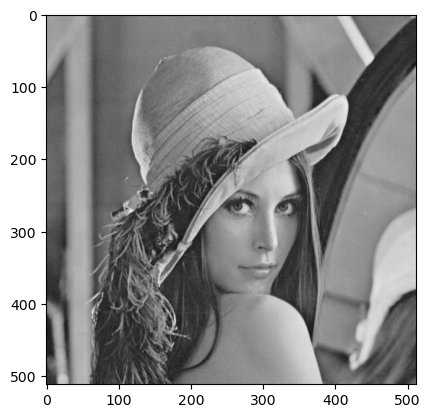

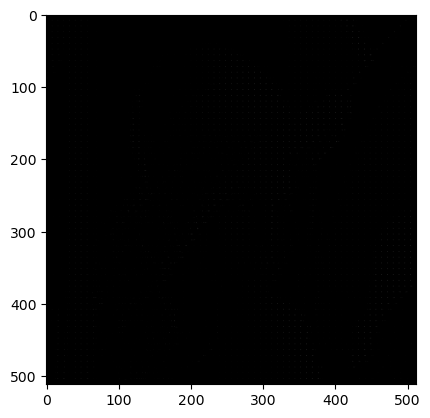

In [20]:
from PIL import Image
import numpy as np

# Nome do arquivo
nome_imagem = 'lena512.pgm'

# Carregar a imagem
img = Image.open(nome_imagem)

# Converter a imagem para numpy array
img_array = np.array(img)

# Agora você pode passar img_array para a função encode_jpeg
new_img = encode_jpeg(img_array, apply_dct, QM, plot=True)
new_new_img = lz77_compress(new_img)

In [24]:
def lz77_decompress(compressed_data, window_size=256, buffer_size=16):
    decompressed_data = bytearray()  # Inicializa a lista para armazenar os dados descomprimidos
    pos = 0  # Inicializa a posição atual

    while pos < len(compressed_data):  # Enquanto não chegarmos ao final dos dados comprimidos
        # Recupera o offset e o comprimento dos dados comprimidos
        offset = (compressed_data[pos] << 8) | compressed_data[pos + 1]
        length = compressed_data[pos + 2]

        # Se o comprimento for 0, então temos um único byte de dados não comprimidos
        if length == 0:
            decompressed_data.append(compressed_data[pos + 3])
            pos += 4
        else:
            # Caso contrário, copiamos 'length' bytes de 'offset' posições atrás nos dados descomprimidos
            for i in range(length):
                if offset <= len(decompressed_data):  # Verifica se o offset é válido
                    decompressed_data.append(decompressed_data[-offset])
                else:
                    break  # Interrompe o loop se o offset não for válido
            pos += 3

    return bytes(decompressed_data)

In [27]:
old_img = lz77_decompress(new_new_img)
old_old_img = decode_jpeg(old_img, apply_dct, QM, plot=True)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe8 in position 18683: invalid continuation byte